In [26]:
##1
import numpy as np
import pandas as pd
df = pd.read_excel('/Users/lubna/Desktop/Online Retail.xlsx')
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(df["Description"].values.reshape(-1, 1))
df.iloc[:, df.columns.get_loc("Description")] = imputed_data
df.dropna(subset=['CustomerID'], inplace=True)


In [30]:
df = df.drop_duplicates()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('int64')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [36]:
#2
customer_summary = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',         
    'InvoiceNo': 'nunique',     
    'Quantity': 'sum',             
}).rename(columns={
    'TotalPrice': 'TotalSpending',
    'InvoiceNo': 'OrderFrequency',
    'Quantity': 'TotalQuantity'
})
customer_summary['AvgBasketSize'] = customer_summary['TotalSpending'] /customer_summary['OrderFrequency']
customer_summary

,TotalSpending,OrderFrequency,TotalQuantity,AvgBasketSize
CustomerID,,,,
12346,0.00,2,0,0.000000
12347,4310.00,7,2458,615.714286
12348,1797.24,4,2341,449.310000
12349,1757.55,1,631,1757.550000
12350,334.40,1,197,334.400000
...,...,...,...,...
18280,180.60,1,45,180.600000
18281,80.82,1,54,80.820000
18282,176.60,3,98,58.866667


In [38]:
current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency.columns = ['CustomerID', 'LastPurchaseDate']
recency['Recency'] = (current_date - recency['LastPurchaseDate']).dt.days
customer_summary = customer_summary.merge(recency[['CustomerID', 'Recency']], on='CustomerID')
customer_summary

,CustomerID,TotalSpending,OrderFrequency,TotalQuantity,AvgBasketSize,Recency
0,12346,0.00,2,0,0.000000,326
1,12347,4310.00,7,2458,615.714286,2
2,12348,1797.24,4,2341,449.310000,75
3,12349,1757.55,1,631,1757.550000,19
4,12350,334.40,1,197,334.400000,310
...,...,...,...,...,...,...
4367,18280,180.60,1,45,180.600000,278
4368,18281,80.82,1,54,80.820000,181
4369,18282,176.60,3,98,58.866667,8
4370,18283,2045.53,16,1357,127.845625,4


In [40]:
customer_summary.to_csv('Customer_Summary.csv', index=False)
print(customer_summary.head())


   CustomerID  TotalSpending  OrderFrequency  TotalQuantity  AvgBasketSize  \
0       12346           0.00               2              0       0.000000   
1       12347        4310.00               7           2458     615.714286   
2       12348        1797.24               4           2341     449.310000   
3       12349        1757.55               1            631    1757.550000   
4       12350         334.40               1            197     334.400000   

   Recency  
0      326  
1        2  
2       75  
3       19  
4      310  


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
customer_summary = pd.read_csv('Customer_Summary.csv')
features = ['TotalSpending', 'OrderFrequency', 'TotalQuantity', 'AvgBasketSize', 'Recency']
x = customer_summary[features]
x = StandardScaler().fit_transform(x)
pca = PCA()
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df['CustomerID'] = customer_summary['CustomerID']
pca_df

,PC1,PC2,PC3,PC4,PC5,CustomerID
0,-1.117462,1.447088,1.738880,-0.057909,0.024641,12346
1,0.854627,-0.293963,-0.938457,-0.094744,-0.017010,12347
2,0.241147,0.118063,-0.364243,0.060984,-0.203824,12348
3,1.135313,1.491820,-3.424761,-1.213512,-0.082667,12349
4,-0.794835,1.816435,0.963854,-0.296150,-0.009067,12350
...,...,...,...,...,...,...
4367,-0.901897,1.358847,1.079366,-0.074611,0.017500,18280
4368,-0.820580,0.475932,0.730989,0.235163,0.022145,18281
4369,-0.419435,-0.963831,-0.111216,0.469261,0.033701,18282
4370,0.560178,-1.341589,0.323448,-0.429738,-0.001204,18283


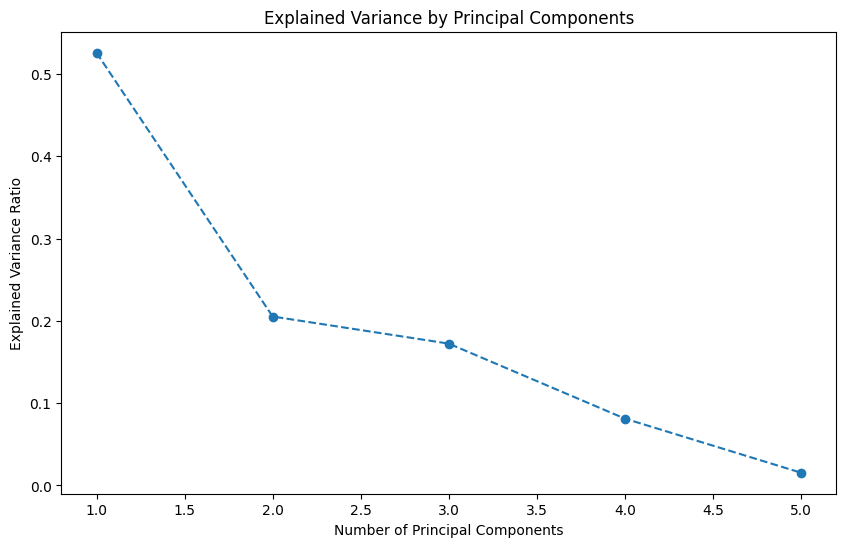

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()


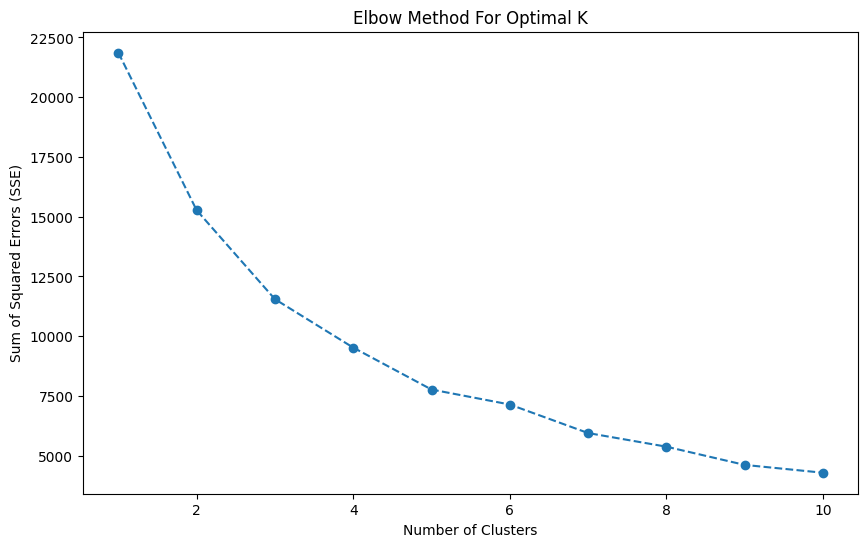

In [48]:
from sklearn.cluster import KMeans
import numpy as np
pca_features = pca_df.iloc[:, :-1]
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', linestyle='--')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()


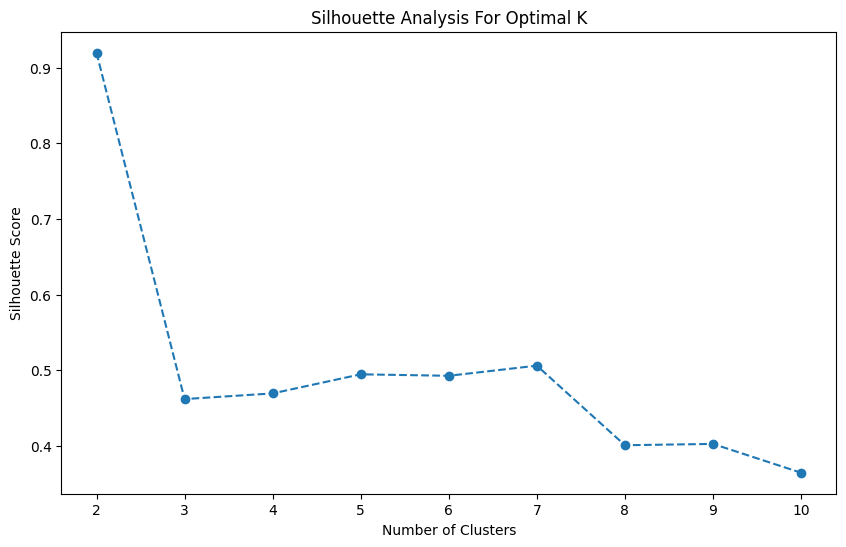

In [50]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    score = silhouette_score(pca_features, kmeans.labels_)
    silhouette_scores.append(score)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


   Cluster    CustomerID  TotalSpending  OrderFrequency  TotalQuantity  \
0        0  15272.356481    1789.364992        5.537654    1062.783642   
1        1  15192.875000   49392.947083       82.791667   32614.041667   
2        2  15380.900362     406.314303        1.848732     235.147645   
3        3  15653.250000  211743.782500       55.000000  101773.000000   

   AvgBasketSize     Recency  
0     332.508743   40.299074  
1     881.913995    5.458333  
2     235.994047  246.100543  
3    3982.590250    8.750000  


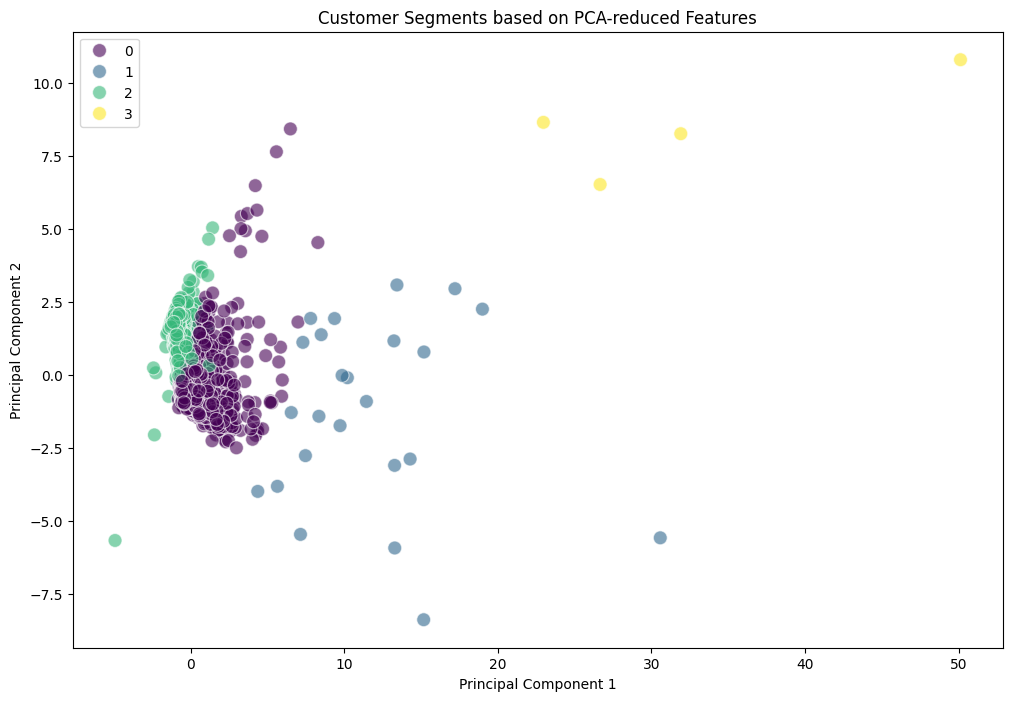

In [56]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_features)
pca_df['Cluster'] = kmeans.labels_
customer_summary['Cluster'] = pca_df['Cluster']
cluster_analysis = customer_summary.groupby('Cluster').mean().reset_index()
print(cluster_analysis)
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.6)
plt.title('Customer Segments based on PCA-reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [58]:
customer_summary['Cluster'] = pca_df['Cluster']
cluster_profile = customer_summary.groupby('Cluster').mean().reset_index()
print(cluster_profile)


   Cluster    CustomerID  TotalSpending  OrderFrequency  TotalQuantity  \
0        0  15272.356481    1789.364992        5.537654    1062.783642   
1        1  15192.875000   49392.947083       82.791667   32614.041667   
2        2  15380.900362     406.314303        1.848732     235.147645   
3        3  15653.250000  211743.782500       55.000000  101773.000000   

   AvgBasketSize     Recency  
0     332.508743   40.299074  
1     881.913995    5.458333  
2     235.994047  246.100543  
3    3982.590250    8.750000  


In [60]:
metrics = ['TotalSpending', 'OrderFrequency', 'TotalQuantity', 'AvgBasketSize', 'Recency']
cluster_metrics = customer_summary.groupby('Cluster')[metrics].mean().reset_index()
print(cluster_metrics)


   Cluster  TotalSpending  OrderFrequency  TotalQuantity  AvgBasketSize  \
0        0    1789.364992        5.537654    1062.783642     332.508743   
1        1   49392.947083       82.791667   32614.041667     881.913995   
2        2     406.314303        1.848732     235.147645     235.994047   
3        3  211743.782500       55.000000  101773.000000    3982.590250   

      Recency  
0   40.299074  
1    5.458333  
2  246.100543  
3    8.750000  


In [62]:
df_with_clusters = df.merge(customer_summary[['CustomerID', 'Cluster']], on='CustomerID')
popular_products = df_with_clusters.groupby(['Cluster', 'StockCode']).agg({
    'Quantity': 'sum'
}).reset_index()
top_products = popular_products.sort_values(['Cluster', 'Quantity'], ascending=[True, False])
print(top_products.groupby('Cluster').head(5))


       Cluster StockCode  Quantity
2477         0     84077     34535
1000         0     22197     31724
2577         0     84879     30380
3299         0    85099B     29099
1379         0     22616     23927
4482         1     22197     16253
5843         1     84077     13639
6406         1    85099B     12530
3614         1     17003     10577
4283         1     21915      9135
8601         2     84077      4945
9221         2    85123A      2380
6572         2     15036      2180
7747         2     22492      2089
6597         2     17096      2067
10073        3     23084      6337
9665         3     22189      5946
9763         3     22469      5661
9840         3     22629      5452
9841         3     22630      5120


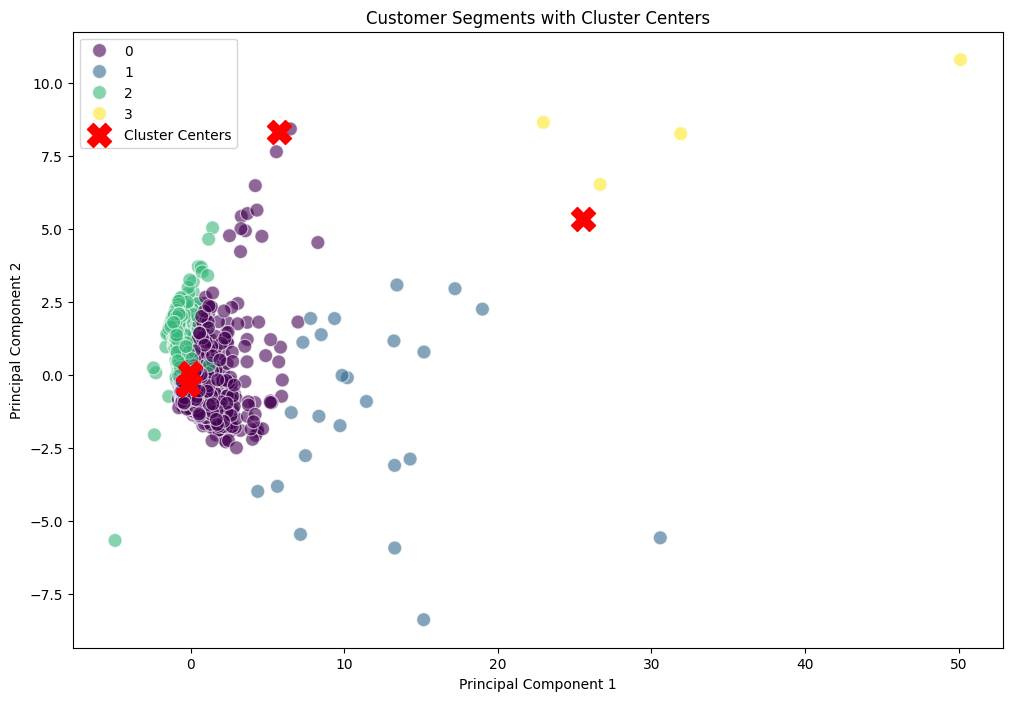

In [69]:
cluster_centers = kmeans.cluster_centers_
cluster_centers_transformed = pca.inverse_transform(cluster_centers)
centers_df = pd.DataFrame(data=cluster_centers_transformed, columns=[f'PC{i+1}' for i in range(cluster_centers_transformed.shape[1])])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.6, legend='full')
plt.scatter(centers_df['PC1'], centers_df['PC2'], s=300, c='red', label='Cluster Centers', marker='X')
plt.title('Customer Segments with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [74]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_df.iloc[:, :-1], kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')
wcss = kmeans.inertia_
print(f'Within-Cluster Sum of Squares (WCSS): {wcss}')


Silhouette Score: -0.07611516267782228
Within-Cluster Sum of Squares (WCSS): 9520.627889699539


Personalized Marketing Strategies, Product Suggestions, and Communication Methods by Cluster:
              Cluster                               Marketing Strategy  \
0       High Spenders            Exclusive promotions, loyalty rewards   
1     Frequent Buyers  Upselling, cross-selling complementary products   
2    Average Spenders       Incentives, discounts for larger purchases   
3  Inactive Customers       Reactivation campaigns with special offers   

                 Product Suggestions                     Communication Methods  
0         Premium or luxury products          Personalized emails, direct mail  
1  Related or complementary products        Email marketing, SMS notifications  
2  Best-selling or trending products            Social media posts, online ads  
3      Discounted or clearance items  Targeted email campaigns with incentives  


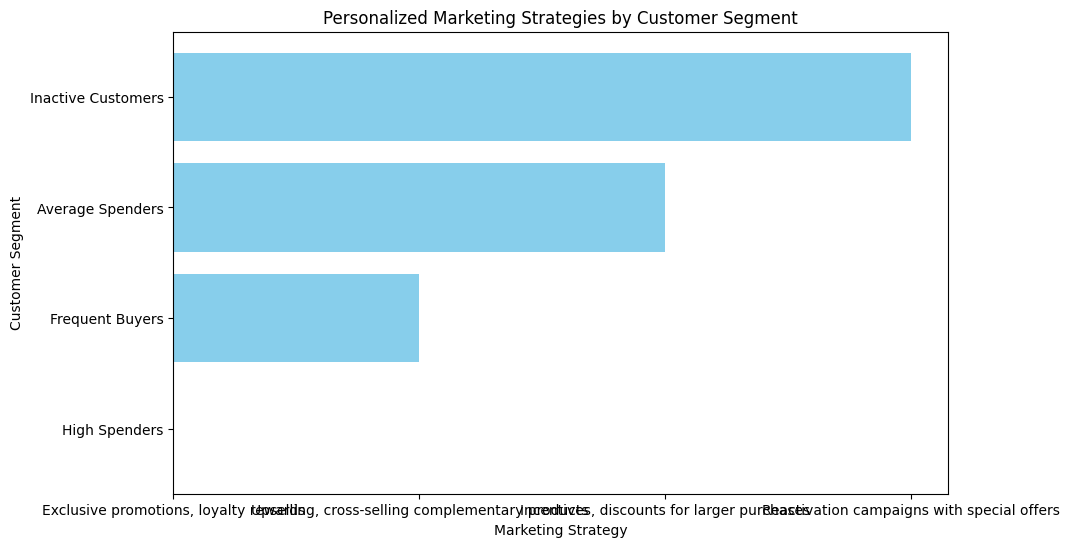

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_data = {
    'Cluster': ['High Spenders', 'Frequent Buyers', 'Average Spenders', 'Inactive Customers'],
    'Marketing Strategy': [
        'Exclusive promotions, loyalty rewards',
        'Upselling, cross-selling complementary products',
        'Incentives, discounts for larger purchases',
        'Reactivation campaigns with special offers'
    ],
    'Product Suggestions': [
        'Premium or luxury products',
        'Related or complementary products',
        'Best-selling or trending products',
        'Discounted or clearance items'
    ],
    'Communication Methods': [
        'Personalized emails, direct mail',
        'Email marketing, SMS notifications',
        'Social media posts, online ads',
        'Targeted email campaigns with incentives'
    ]
}

# Create DataFrame
df = pd.DataFrame(cluster_data)

# Display personalized marketing strategies, product suggestions, and communication methods
print("Personalized Marketing Strategies, Product Suggestions, and Communication Methods by Cluster:")
print(df)

# Plotting marketing strategies
plt.figure(figsize=(10, 6))
plt.barh(df['Cluster'], df['Marketing Strategy'], color='skyblue')
plt.xlabel('Marketing Strategy')
plt.ylabel('Customer Segment')
plt.title('Personalized Marketing Strategies by Customer Segment')
plt.show()


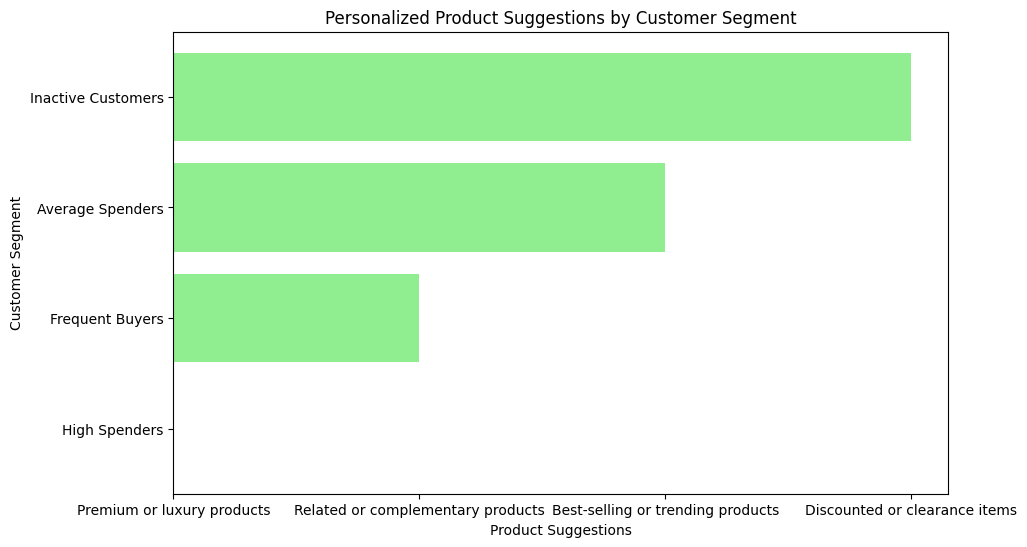

In [80]:
# Plotting product suggestions
plt.figure(figsize=(10, 6))
plt.barh(df['Cluster'], df['Product Suggestions'], color='lightgreen')
plt.xlabel('Product Suggestions')
plt.ylabel('Customer Segment')
plt.title('Personalized Product Suggestions by Customer Segment')
plt.show()

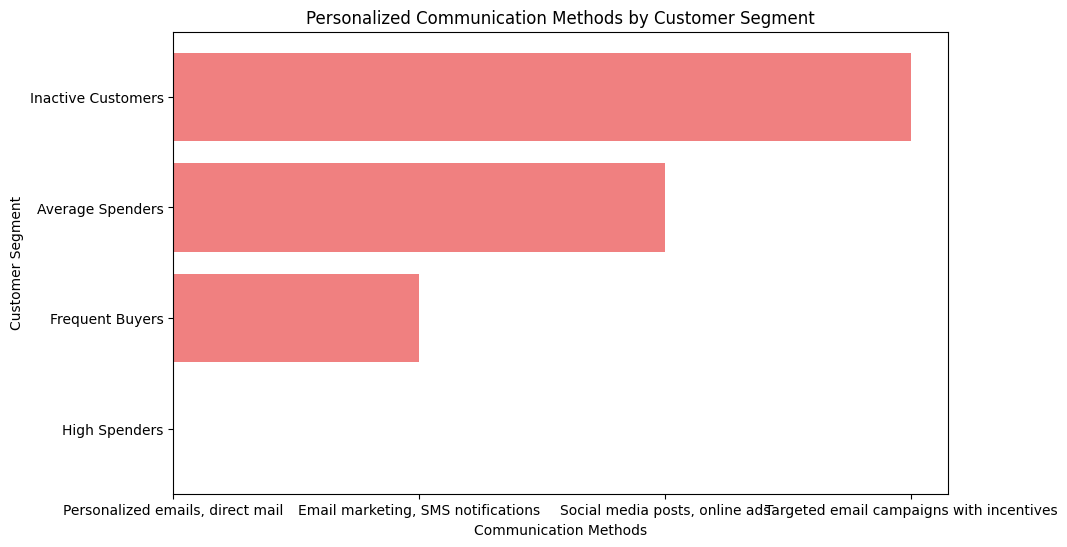

In [82]:

# Plotting communication methods
plt.figure(figsize=(10, 6))
plt.barh(df['Cluster'], df['Communication Methods'], color='lightcoral')
plt.xlabel('Communication Methods')
plt.ylabel('Customer Segment')
plt.title('Personalized Communication Methods by Customer Segment')
plt.show()


Customer Segments Analysis:
   CustomerID             Segment  TotalSpending  OrderFrequency  Recency
0           1       High Spenders           5000              10       30
1           2     Frequent Buyers           3000              20       15
2           3    Average Spenders           1000               5       60
3           4  Inactive Customers              0               0       90


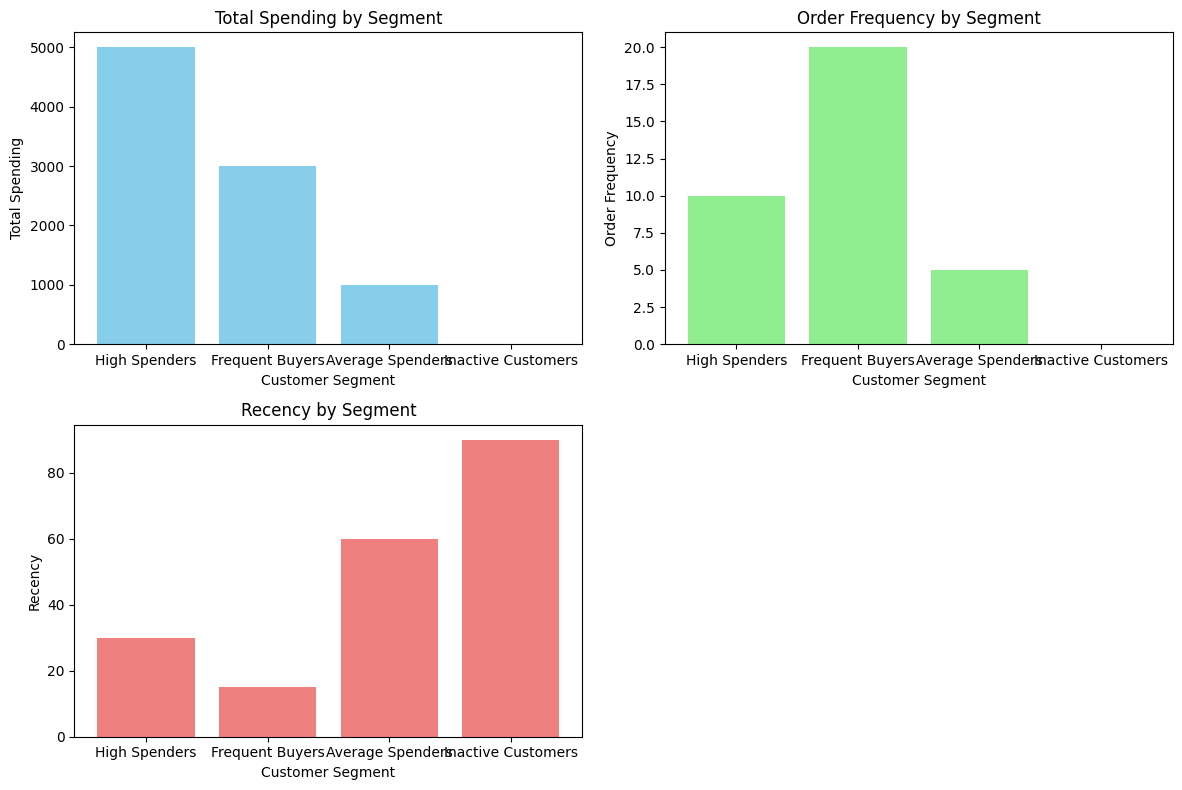


Implications for E-commerce Business:
Targeted Marketing: Tailor marketing strategies based on segment characteristics.
Customer Retention Strategies: Implement personalized retention campaigns.
Inventory Management: Optimize inventory based on segment preferences.

Continuous Optimization:
Monitor and Adjust: Regularly assess and refine segmentation strategies.
Experimentation: Experiment with different marketing initiatives and offers.
Feedback Loop: Gather customer feedback to improve strategies.

Insights and Recommendations:
Segment-Specific Strategies: Develop tailored campaigns for each segment.
Dynamic Adaptation: Adjust strategies based on evolving customer behavior.
Customer-Centric Approach: Prioritize personalized experiences for customers.


In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample customer segmentation data (replace with actual data)
customer_segments = {
    'CustomerID': [1, 2, 3, 4],
    'Segment': ['High Spenders', 'Frequent Buyers', 'Average Spenders', 'Inactive Customers'],
    'TotalSpending': [5000, 3000, 1000, 0],
    'OrderFrequency': [10, 20, 5, 0],
    'Recency': [30, 15, 60, 90]
}

# Create DataFrame
df_segments = pd.DataFrame(customer_segments)

# 10. Interpretation and Insights
# Customer Segments Analysis
print("Customer Segments Analysis:")
print(df_segments)

# Plotting customer segments characteristics
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(df_segments['Segment'], df_segments['TotalSpending'], color='skyblue')
plt.title('Total Spending by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Spending')

plt.subplot(2, 2, 2)
plt.bar(df_segments['Segment'], df_segments['OrderFrequency'], color='lightgreen')
plt.title('Order Frequency by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Order Frequency')

plt.subplot(2, 2, 3)
plt.bar(df_segments['Segment'], df_segments['Recency'], color='lightcoral')
plt.title('Recency by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

# Implications for E-commerce Business
print("\nImplications for E-commerce Business:")
print("Targeted Marketing: Tailor marketing strategies based on segment characteristics.")
print("Customer Retention Strategies: Implement personalized retention campaigns.")
print("Inventory Management: Optimize inventory based on segment preferences.")

# Continuous Optimization
print("\nContinuous Optimization:")
print("Monitor and Adjust: Regularly assess and refine segmentation strategies.")
print("Experimentation: Experiment with different marketing initiatives and offers.")
print("Feedback Loop: Gather customer feedback to improve strategies.")

# Insights and Recommendations
print("\nInsights and Recommendations:")
print("Segment-Specific Strategies: Develop tailored campaigns for each segment.")
print("Dynamic Adaptation: Adjust strategies based on evolving customer behavior.")
print("Customer-Centric Approach: Prioritize personalized experiences for customers.")

